# Predicting Playing Time in US National Women's Soccer League
## Using data collected by FBref.com, predict the amount of playing time that a player will have based upon current data.  

In [156]:
import requests, bs4
from bs4 import BeautifulSoup as bs
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score

Explore the FBref.com dataset

In [2]:
# url = 'https://fbref.com/en/squads/1c912aa0/2019/United-States-Stats'
#url = 'https://fbref.com/en/comps/182/stats/NWSL-Stats' - can't use comps because tables are commented out in HTML
#url = 'https://fbref.com/en/squads/df9a10a1/Portland-Thorns-FC-Stats'
url='https://fbref.com/en/squads/df9a10a1/2019/Portland-Thorns-FC-Stats'
response = requests.get(url)
status = response.status_code
if status == 200:
  page = response.text
  soup = bs(page)
else:
  print(f"Oops! Received status code {status}")


# Collecting Information from One Page

Extract player name, nationality, position, age, games played, games started, minutes played, minutes played/90, goals scored, assists made, penalty kicks made, penalty kicks attempted, yellow cards received and red cards received.

Cleaning age to remove the Day/Month.

In [3]:
# author_list = [author.text.replace('By','').split('\u2022')[0].strip() for author in soup.find_all(class_='blog-post-details')][:5]
def get_players(soup):
    player_list = []
#     stats_table = soup.find('table', id=re.compile('stats_standard')).tbody
    stats_table = soup.find(class_='stats_table').tbody
    for row in stats_table.find_all('tr'): 
        player = row.find(attrs={'data-stat':'player','scope':'row','csk':True}).text
        nation = row.find(attrs={'data-stat':'nationality'}).text
        nationality = age_row = 'None' if (nation == '') else nation.split()[1].strip()
        pos= row.find(attrs={'data-stat':'position','csk':True}).text
        age = row.find(attrs={'data-stat':'age'}).text.split('-')[0]
        games = row.find(attrs={'data-stat':'games'}).text.strip()
        games_starts = row.find(attrs={'data-stat':'games_starts'}).text.strip()
        minutes = row.find(attrs={'data-stat':'minutes'}).text.replace(',','')
        minutes_90s = row.find(attrs={'data-stat':'minutes_90s'}).text
        goals = row.find(attrs={'data-stat':'goals'}).text
        assists = row.find(attrs={'data-stat':'assists'}).text
        pens_made = row.find(attrs={'data-stat':'pens_made'}).text
        pens_att = row.find(attrs={'data-stat':'pens_att'}).text
        cards_yellow = row.find(attrs={'data-stat':'cards_yellow'}).text
        cards_red = row.find(attrs={'data-stat':'cards_red'}).text
        goals_per90 = row.find(attrs={'data-stat':'goals_per90'}).text
        assists_per90 = row.find(attrs={'data-stat':'assists_per90'}).text
        goals_assists_per90 = row.find(attrs={'data-stat':'goals_assists_per90'}).text
        goals_pens_per90 = row.find(attrs={'data-stat':'goals_pens_per90'}).text
        goals_assists_pens_per90 = row.find(attrs={'data-stat':'goals_assists_pens_per90'}).text
        player_list.append({'player':player, 'nationality':nationality, 'pos':pos, 'age': age, 'games':games, 'games_starts':games_starts, 
                           'minutes':minutes, 'minutes_90s':minutes_90s, 'goals':goals, 'assists': assists,
                           'pens_made':pens_made, 'pens_att': pens_att, 'cards_yellow':cards_yellow,
                           'cards_red':cards_red,'goals_per90':goals_per90,'assists_per90':assists_per90,
                           'goals_assists_per90':goals_assists_per90, 'goals_pens_per90':goals_pens_per90,
                            'goals_assists_pens_per90':goals_assists_pens_per90
                           })
    return(player_list)

player_df = pd.DataFrame(get_players(soup))
player_df


,player,nationality,pos,age,games,games_starts,minutes,minutes_90s,goals,assists,pens_made,pens_att,cards_yellow,cards_red,goals_per90,assists_per90,goals_assists_per90,goals_pens_per90,goals_assists_pens_per90
0,Meghan Klingenberg,USA,"DF,MF",30,23,23,2014,22.4,0,4,0,0,1,0,0.00,0.18,0.18,0.00,0.18
1,Emily Menges,USA,DF,26,19,19,1665,18.5,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00
2,Katherine Reynolds,USA,DF,31,23,17,1656,18.4,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00
3,Dagný Brynjarsdóttir,ISL,MF,27,21,17,1565,17.4,1,0,0,0,3,0,0.06,0.00,0.06,0.06,0.06
4,Christine Sinclair,CAN,"MF,FW",35,17,17,1530,17.0,9,1,3,3,0,0,0.53,0.06,0.59,0.35,0.41
5,Margaret Purce,USA,"FW,MF",23,22,16,1326,14.7,8,1,0,0,0,0,0.54,0.07,0.61,0.54,0.61
6,Adrianna Franch,USA,GK,28,14,14,1260,14.0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00
7,Ellie Carpenter,AUS,"DF,MF",18,16,14,1218,13.5,0,1,0,0,0,0,0.00,0.07,0.07,0.00,0.07
8,Lindsey Horan,USA,MF,24,13,13,1145,12.7,1,2,0,0,2,0,0.08,0.16,0.24,0.08,0.24
9,Gabby Seiler,USA,"MF,DF",24,15,13,1122,12.5,0,0,0,0,1,0,0.00,0.00,0.00,0.00,0.00


## Collecting Player Information from Multiple Pages



You will need to create a web scraping pipeline to do this.  Remember the main steps:
1. Gather links -- develop a strategy for straping past posts
2. Scrape the same data from each page
3. Clean the data as necessary

Save the information as one dictionary for each post (as described in Exercise 1) and put all the posts in a list called `pipeline_list`. 

In [4]:
def get_web_page(url):
    response = requests.get(url)
    status = response.status_code
    if status == 200:
        return response.text
    else:
        print(f"Oops! Received status code {status}")
        return ""


url_base='https://fbref.com'
url_start='https://fbref.com/en/comps/182/history/NWSL-Seasons'
page = get_web_page(url_start)
soup = bs(page)
seasons_table = soup.find(id='seasons').tbody
# get a list of all of the seasons, minus outlier years 2020, 2021(incomplete season)
season_url_list = []
for season in seasons_table.find_all('tr'):
    season_year = season.find(attrs={'data-stat':'season'}).text
    if season_year not in ['2020', '2021']: #avoid incomplete season and covid
        season_url_list.append(season.find(attrs={'data-stat':'season'}).a['href'])

#get list of urls of squad pages from 2019 and prior
squads_url_list = []
for season_url in season_url_list:
    page = get_web_page(url_base+season_url)
    soup = bs(page)
    team_table = soup.find(class_='stats_table').tbody
    for squad in team_table.find_all('tr'):
        squads_url_list.append(squad.find(attrs={'data-stat':'squad'}).a['href'])

# urls = eam in [url_base+str(i) for i in range(1,6)]
# for link in urls :
#     page = get_web_page(link)
#     soup = bs(page)

#     for blog in soup.find_all(class_='blog-post-summary'):
#         title = blog.find(class_='blog-post-title').text
#         author = blog.find(class_='blog-post-details').text.replace('By','').split('\u2022')[0].strip()
#         link = blog.find(class_='blog-post-title').parent['href']
#         pipeline_list.append({'title':title, 'author':author,'link':link})
    
# pipeline_list[-5:]

In [5]:

player_list_df = pd.DataFrame(columns = ['player', 'nationality', 'pos', 'age', 'games', 'games_starts', 
                           'minutes', 'minutes_90s', 'goals', 'assists',
                           'pens_made', 'pens_att', 'cards_yellow','cards_red',
                            'goals_per90','assists_per90','goals_assists_per90', 'goals_pens_per90','goals_assists_pens_per90'])
# page = get_web_page(url_base+squads_url_list[0])
# soup = bs(page)
# player_list_df = player_list_df.append(pd.DataFrame(get_players(soup)))
for squad_url in squads_url_list :
    page = get_web_page(url_base+squad_url)
    soup = bs(page)
    player_list_df = player_list_df.append(pd.DataFrame(get_players(soup)),ignore_index=True)
player_list_df 


,player,nationality,pos,age,games,games_starts,minutes,minutes_90s,goals,assists,pens_made,pens_att,cards_yellow,cards_red,goals_per90,assists_per90,goals_assists_per90,goals_pens_per90,goals_assists_pens_per90
0,Jaelene Hinkle,USA,DF,25,24,24,2160,24.0,1,6,0,0,1,0,0.04,0.25,0.29,0.04,0.29
1,Denise O'Sullivan,IRL,MF,24,23,22,1965,21.8,0,1,0,0,4,0,0.00,0.05,0.05,0.00,0.05
2,Lynn Williams,USA,FW,25,22,21,1847,20.5,12,5,0,1,0,0,0.58,0.24,0.83,0.58,0.83
3,Abby Erceg,NZL,DF,29,20,20,1774,19.7,1,0,0,0,1,0,0.05,0.00,0.05,0.05,0.05
4,Merritt Mathias,USA,"DF,MF",28,20,20,1770,19.7,0,5,0,0,0,0,0.00,0.25,0.25,0.00,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1613,Chantel Jones,USA,GK,24,4,4,350,3.9,,,0,0,,,,,,,
1614,Lindsay Taylor,USA,FW,23,6,2,239,2.7,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00
1615,Colleen Williams,USA,"FW,MF",21,6,2,129,1.4,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00
1616,Caroline Miller,USA,FW,21,7,1,199,2.2,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00


In [6]:
player_list_df.dtypes


player                      object
nationality                 object
pos                         object
age                         object
games                       object
games_starts                object
minutes                     object
minutes_90s                 object
goals                       object
assists                     object
pens_made                   object
pens_att                    object
cards_yellow                object
cards_red                   object
goals_per90                 object
assists_per90               object
goals_assists_per90         object
goals_pens_per90            object
goals_assists_pens_per90    object
dtype: object

In [7]:
player_list_df = player_list_df.replace(r'^\s*$', 0, regex=True)

In [8]:
player_list_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1618 entries, 0 to 1617
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   player                    1618 non-null   object
 1   nationality               1618 non-null   object
 2   pos                       1618 non-null   object
 3   age                       1618 non-null   object
 4   games                     1618 non-null   object
 5   games_starts              1618 non-null   object
 6   minutes                   1618 non-null   object
 7   minutes_90s               1618 non-null   object
 8   goals                     1618 non-null   object
 9   assists                   1618 non-null   object
 10  pens_made                 1618 non-null   object
 11  pens_att                  1618 non-null   object
 12  cards_yellow              1618 non-null   object
 13  cards_red                 1618 non-null   object
 14  goals_per90             

In [9]:
player_list_df = player_list_df.astype({'age':'int32','games': 'int32','games_starts':'int32', 'minutes':'int32', 'minutes_90s':'float',
                       'goals':'int32', 'assists':'int32', 'pens_made':'int32', 'pens_att':'int32',
                       'cards_yellow':'int32','cards_red':'int32',
                        'goals_per90':'float','assists_per90':'float','goals_assists_per90':'float', 'goals_pens_per90':'float','goals_assists_pens_per90':'float'})

In [104]:
# How many 0 elements in each category
player_list_df.drop(player_list_df[(player_list_df.pos == 'GK')].index, inplace=True)


In [106]:
player_list_df.shape

(1435, 19)

## Store player list for safekeeping

In [107]:
player_list_df.to_csv('player_list.csv', index=False)

## Scope Out Regression Viability



In [108]:
player_list_df.corr()

,age,games,games_starts,minutes,minutes_90s,goals,assists,pens_made,pens_att,cards_yellow,cards_red,goals_per90,assists_per90,goals_assists_per90,goals_pens_per90,goals_assists_pens_per90
age,1.000000,0.224727,0.252623,0.239535,0.239685,0.139506,0.122165,0.115313,0.126957,0.133344,0.064977,0.034271,0.063164,0.100440,0.033429,0.091163
games,0.224727,1.000000,0.913535,0.913119,0.913017,0.410709,0.444192,0.164412,0.194863,0.477169,0.071395,0.047778,0.101104,0.149671,0.046896,0.140705
games_starts,0.252623,0.913535,1.000000,0.977266,0.977243,0.412945,0.449986,0.202532,0.237655,0.483340,0.076833,0.031604,0.066859,0.101734,0.030512,0.089276
minutes,0.239535,0.913119,0.977266,1.000000,0.999994,0.411539,0.455697,0.208671,0.242569,0.482650,0.076594,-0.057295,0.073766,0.113359,-0.058439,0.100403
minutes_90s,0.239685,0.913017,0.977243,0.999994,1.000000,0.411518,0.455728,0.208535,0.242453,0.482630,0.076556,-0.057455,0.073844,0.113340,-0.058599,0.100390
goals,0.139506,0.410709,0.412945,0.411539,0.411518,1.000000,0.565277,0.450732,0.487394,0.170267,0.033824,0.052475,0.201459,0.559643,0.049541,0.531547
assists,0.122165,0.444192,0.449986,0.455697,0.455728,0.565277,1.000000,0.315052,0.360515,0.162811,0.032873,-0.012971,0.463902,0.492958,-0.014898,0.476379
pens_made,0.115313,0.164412,0.202532,0.208671,0.208535,0.450732,0.315052,1.000000,0.935448,0.121872,0.011818,0.003222,0.093866,0.216350,-0.003630,0.132448
pens_att,0.126957,0.194863,0.237655,0.242569,0.242453,0.487394,0.360515,0.935448,1.000000,0.141994,0.015142,0.010158,0.108612,0.234393,0.003838,0.157599
cards_yellow,0.133344,0.477169,0.483340,0.482650,0.482630,0.170267,0.162811,0.121872,0.141994,1.000000,0.158810,0.014099,0.019264,0.024929,0.013429,0.016703


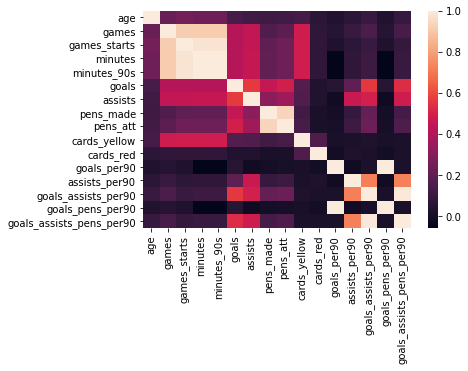

In [109]:
sns.heatmap(player_list_df.corr());

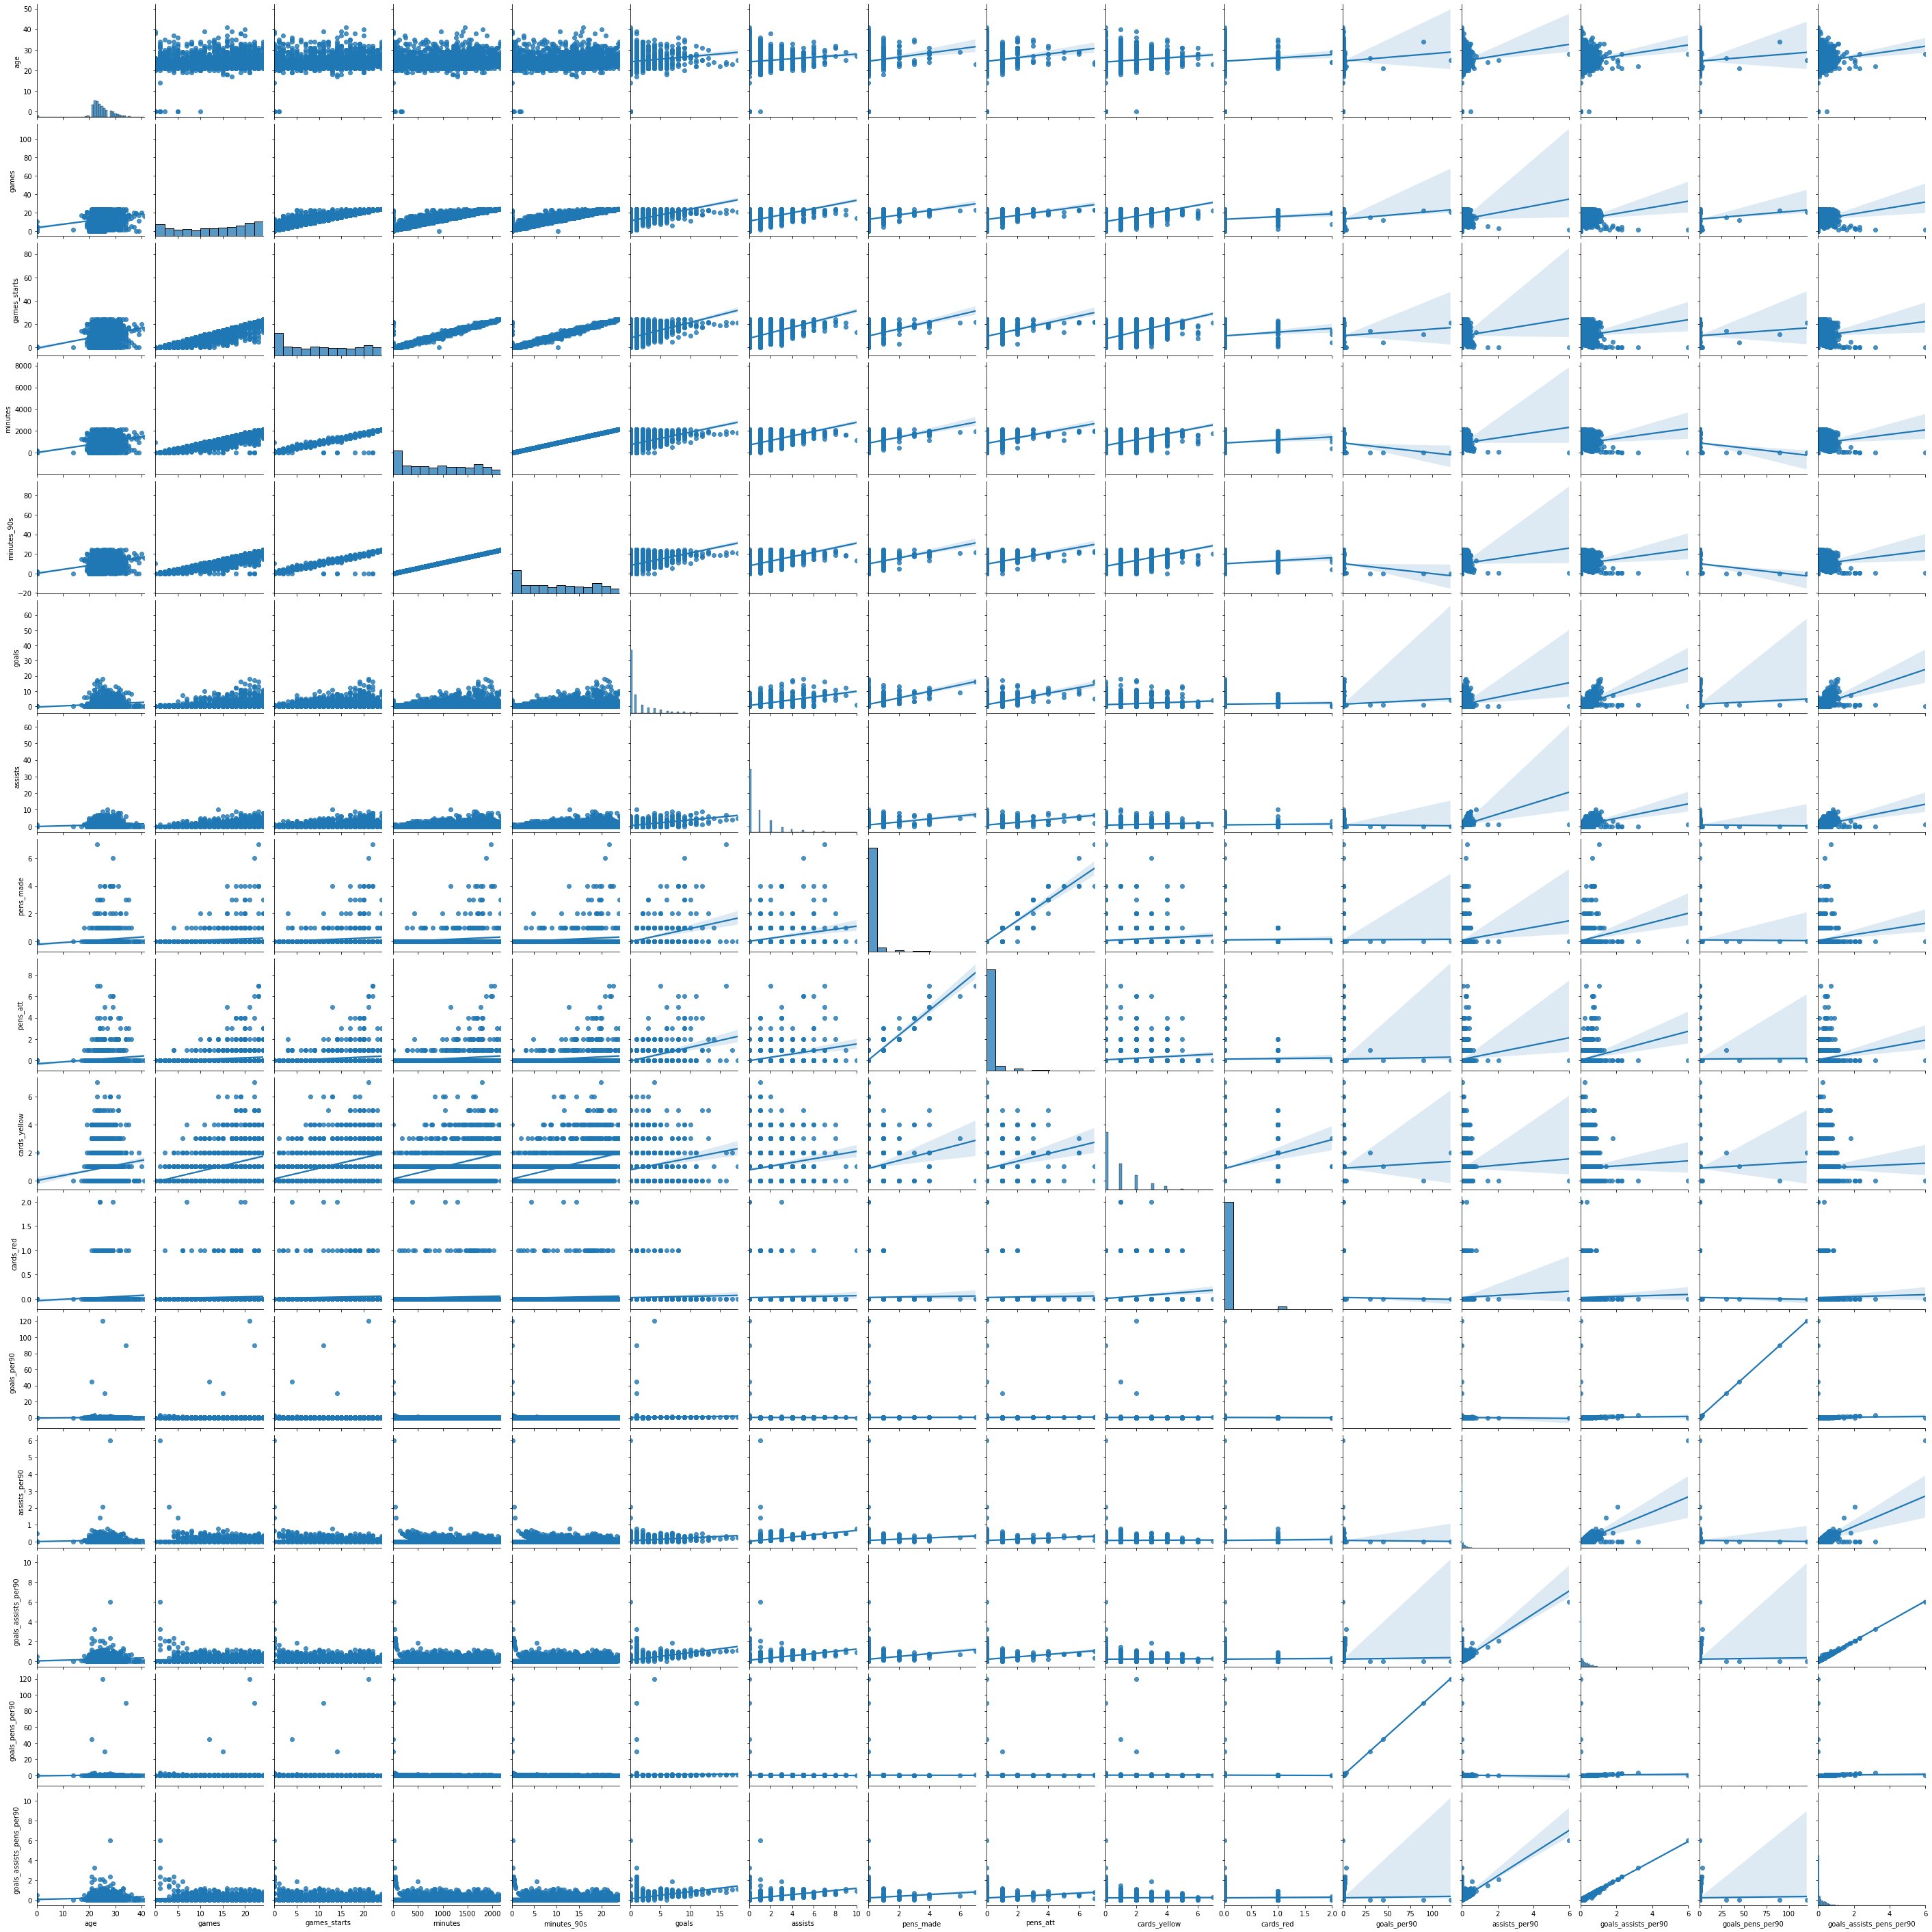

In [110]:
sns.pairplot(player_list_df,kind='reg')

In [111]:
y=player_list_df['minutes']
X=sm.add_constant(player_list_df['goals'])
model=sm.OLS(y,X)
fit = model.fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                minutes   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     292.2
Date:                Tue, 14 Sep 2021   Prob (F-statistic):           9.23e-60
Time:                        16:17:00   Log-Likelihood:                -11246.
No. Observations:                1435   AIC:                         2.250e+04
Df Residuals:                    1433   BIC:                         2.251e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        741.5066     18.524     40.030      0.0

/Users/nbinowski/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Text(0, 0.5, 'Residual')

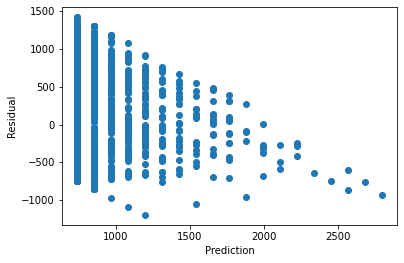

In [112]:
fig=plt.scatter(fit.predict(),fit.resid)
fig.axes.set_xlabel('Prediction')
fig.axes.set_ylabel('Residual')

In [113]:
y=player_list_df['minutes']
X=sm.add_constant(player_list_df['games_starts'])
model=sm.OLS(y,X)
fit = model.fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                minutes   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                 3.045e+04
Date:                Tue, 14 Sep 2021   Prob (F-statistic):               0.00
Time:                        17:48:44   Log-Likelihood:                -9153.4
No. Observations:                1435   AIC:                         1.831e+04
Df Residuals:                    1433   BIC:                         1.832e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           35.9949      6.200      5.806   

/Users/nbinowski/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [114]:
#fig=plt.scatter(fit.predict(),fit.resid)
fit.resid
#fig = plt.scatter(fit.resid, y)

0       74.416873
1       50.215891
2       17.615401
3       30.014910
4       26.014910
          ...    
1612    32.407060
1614    32.206079
1615   -77.793921
1616    77.605588
1617   -35.994903
Length: 1435, dtype: float64

In [122]:
X=player_list_df.drop(columns=['cards_red','assists_per90','games_starts','pens_att','minutes_90s','goals_assists_per90','goals_per90','minutes','player','nationality','pos'])
X.dtypes
X=sm.add_constant(X)
y = player_list_df.loc[:,'minutes']
model=sm.OLS(y,X)
fit = model.fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                minutes   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     1070.
Date:                Tue, 14 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:03:40   Log-Likelihood:                -9982.9
No. Observations:                1435   AIC:                         1.998e+04
Df Residuals:                    1426   BIC:                         2.003e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

/Users/nbinowski/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


#### Try using the minutes_90 as target and see if it changes anything

In [136]:
X90=player_list_df.drop(columns=['cards_red','assists_per90','pens_att','games_starts','goals_per90','goals_assists_per90','minutes','minutes_90s','player','nationality','pos'])
X90=sm.add_constant(X90)
y90 = player_list_df.loc[:,'minutes_90s']
model90=sm.OLS(y90,X90)
fit90 = model90.fit()
print(fit90.summary())

                            OLS Regression Results                            
Dep. Variable:            minutes_90s   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     1069.
Date:                Tue, 14 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:18:59   Log-Likelihood:                -3526.4
No. Observations:                1435   AIC:                             7071.
Df Residuals:                    1426   BIC:                             7118.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

/Users/nbinowski/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


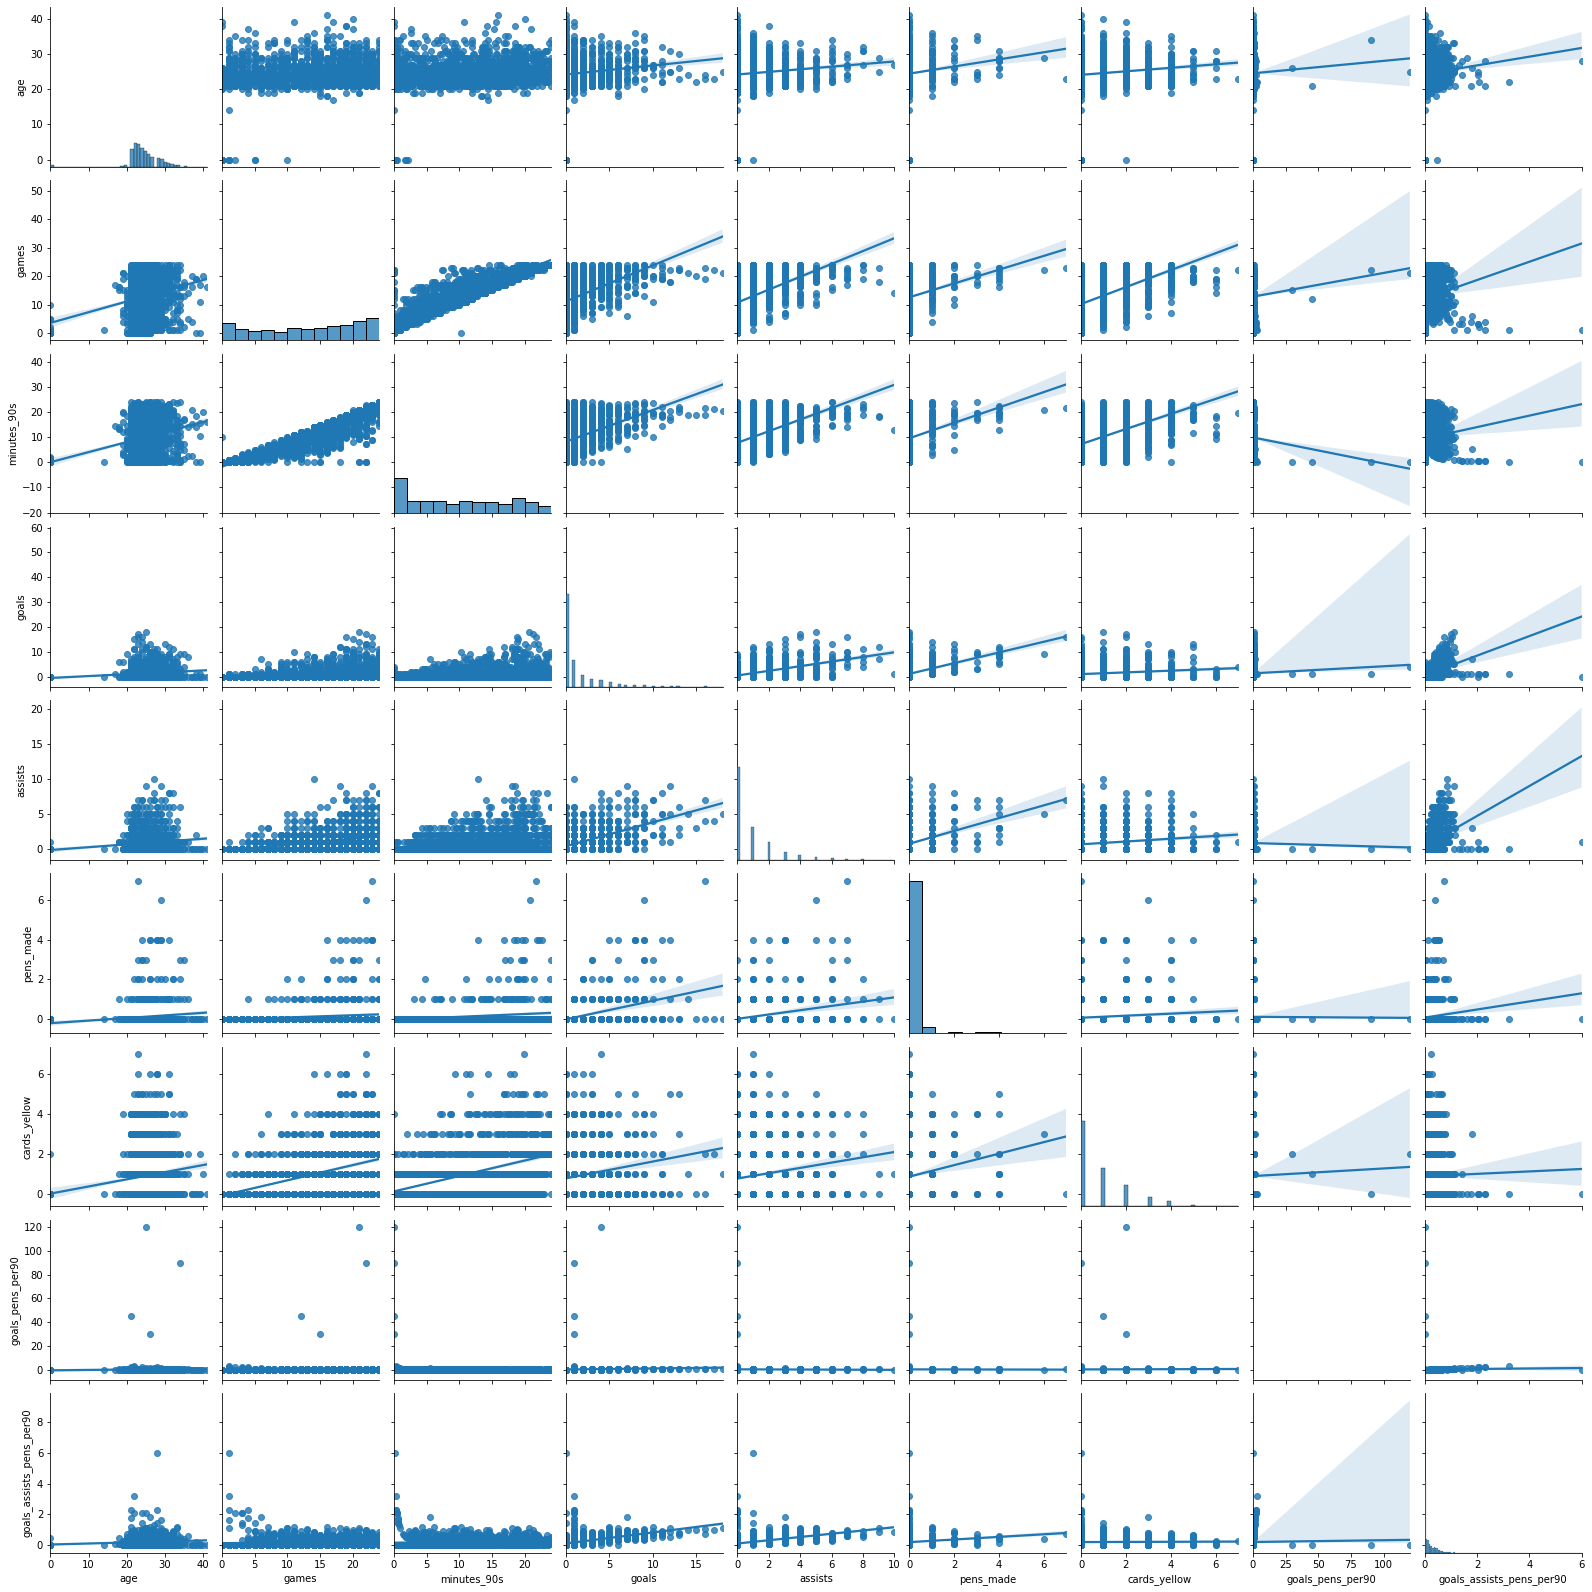

In [140]:
sns.pairplot(player_list_df.drop(columns=['cards_red','assists_per90','pens_att','games_starts','goals_per90','goals_assists_per90','minutes','player','nationality','pos']),kind='reg')

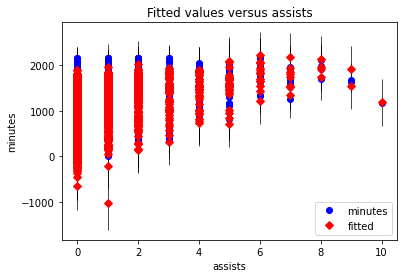

In [124]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(fit, 4, ax=ax)

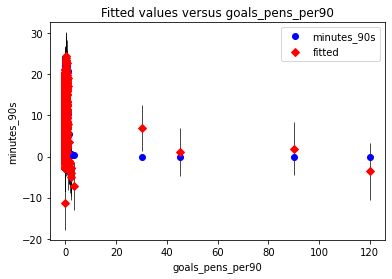

In [125]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(fit90, 7, ax=ax)

#### Measure Influence

<AxesSubplot:ylabel='cooks_d'>

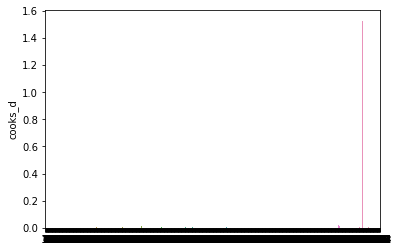

In [126]:
influence = fit.get_influence()
influence_frame = influence.summary_frame().reset_index()
sns.barplot(y='cooks_d', x=influence_frame.index, data=influence_frame)

There are no outliers that are influential points.  Continue...

### Find VIF - variance inflation factor, the correlation between independent variables and the strength of that correlation


In [127]:
variables = fit.model.exog
vif_data=pd.DataFrame()
vif_data['feature']=X.columns
vif_data['VIF'] = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
vif_data

,feature,VIF
0,const,32.065318
1,age,1.065304
2,games,1.741672
3,goals,2.152874
4,assists,1.795037
5,pens_made,1.323718
6,cards_yellow,1.309249
7,goals_pens_per90,1.008510
8,goals_assists_pens_per90,1.598347


In [133]:
variables = fit90.model.exog
vif90_data=pd.DataFrame()
vif90_data['feature']=X90.columns
vif90_data['VIF'] = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
vif90_data

,feature,VIF
0,const,32.113581
1,age,1.067644
2,games,1.742977
3,goals,2.680967
4,assists,2.029920
5,pens_made,1.345792
6,cards_yellow,1.336620
7,cards_red,1.029005
8,assists_per90,2.736394
9,goals_pens_per90,1.008648


## Cross Validation

In [128]:
X, X_test, y, y_test = train_test_split(X, y, 
                                       test_size=.2,     
                                       random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                       test_size=.25,     
                                       random_state=42)

In [164]:
model = LinearRegression()
lr = model.fit(X_train,y_train)

r_squared_train = lr.score(X_train, y_train)
r_squared_val = lr.score(X_val, y_val)
r_squared_test = lr.score(X_test, y_test)

print(r_squared_train)
print(r_squared_val)
print(r_squared_test)
print(r_squared_train-r_squared_test)

0.8652247341080777
0.8186811047122724
0.847864904025212
0.01735983008286568


In [161]:
X90, X90_test, y90, y90_test = train_test_split(X90, y90, 
                                       test_size=.2,     
                                       random_state=42)

X90_train, X90_val, y90_train, y90_val = train_test_split(X90, y90, 
                                       test_size=.25,     
                                       random_state=42)


In [163]:
model = LinearRegression()
lr = model.fit(X90_train,y90_train)

r_squared_train = lr.score(X90_train, y90_train)
r_squared_val = lr.score(X90_val, y90_val)
r_squared_test = lr.score(X90_test, y90_test)

print(r_squared_train)
print(r_squared_val)
print(r_squared_test)
print(r_squared_train-r_squared_test)

0.8540262433860621
0.8655429363851752
0.8494148492587285
0.00461139412733369


# Regularization

In [194]:
X=player_list_df.drop(columns=['minutes','minutes_90s','player','nationality','pos'])
y = player_list_df.loc[:,'minutes_90s']
X, X_test, y, y_test = train_test_split(X, y, 
                                       test_size=.2,     
                                       random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                       test_size=.25,     
                                       random_state=42)



In [195]:
std = StandardScaler()
std.fit(X_train.values)
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

In [196]:
lr_model_ridge = Ridge(alpha = 2000)
lr_model_ridge.fit(X_tr, y_train)
ridge_test_r2 = lr_model_ridge.score(X_te, y_test)

print(lr_model_ridge.score(X_tr, y_train))
print(lr_model_ridge.score(X_te, y_test))
list(zip(X_train.columns, lr_model_ridge.coef_))

0.7024459079386033
0.7087584823654175


[('age', 0.22269215495518915),
 ('games', 1.3946907352972004),
 ('games_starts', 1.5807029523091072),
 ('goals', 0.38162959456451206),
 ('assists', 0.5042500705172624),
 ('pens_made', 0.0996151015272843),
 ('pens_att', 0.15406415537806248),
 ('cards_yellow', 0.6394862252926564),
 ('cards_red', 0.09714435293555544),
 ('goals_per90', -0.13283047712690838),
 ('assists_per90', 0.04824790284858379),
 ('goals_assists_per90', -0.019672757092907472),
 ('goals_pens_per90', -0.13305048049439155),
 ('goals_assists_pens_per90', -0.02331489990407361)]

In [197]:
alphas = 10**np.linspace(-2,2,200)
ridge_model = RidgeCV(alphas = alphas, cv=5)
ridge_model.fit(X_tr, y_train)
r_squared_train = ridge_model.score(X_tr, y_train)
r_squared_test = ridge_model.score(X_te, y_test)
alpha = ridge_model.alpha_

In [198]:
print("r_squared_train:", r_squared_train)
print("r_squared_test:", r_squared_test)
print("difference:",r_squared_train-r_squared_test)
list(zip(X_train.columns, lr_model_ridge.coef_))

r_squared_train: 0.955408406028245
r_squared_test: 0.9718580191807756
difference: -0.016449613152530684


[('age', 0.22269215495518915),
 ('games', 1.3946907352972004),
 ('games_starts', 1.5807029523091072),
 ('goals', 0.38162959456451206),
 ('assists', 0.5042500705172624),
 ('pens_made', 0.0996151015272843),
 ('pens_att', 0.15406415537806248),
 ('cards_yellow', 0.6394862252926564),
 ('cards_red', 0.09714435293555544),
 ('goals_per90', -0.13283047712690838),
 ('assists_per90', 0.04824790284858379),
 ('goals_assists_per90', -0.019672757092907472),
 ('goals_pens_per90', -0.13305048049439155),
 ('goals_assists_pens_per90', -0.02331489990407361)]

In [199]:

lasso = Lasso(alpha = 10000)
lasso.fit(X_tr, y_train)
test_r_squared = lasso.score(X_te, y_test)
print(test_r_squared)
print(list(zip(X_train.columns, lasso.coef_)))

-0.0001954930846144176
[('age', 0.0), ('games', 0.0), ('games_starts', 0.0), ('goals', 0.0), ('assists', 0.0), ('pens_made', 0.0), ('pens_att', 0.0), ('cards_yellow', 0.0), ('cards_red', 0.0), ('goals_per90', -0.0), ('assists_per90', 0.0), ('goals_assists_per90', 0.0), ('goals_pens_per90', -0.0), ('goals_assists_pens_per90', 0.0)]


In [200]:
alphas = 10**np.linspace(-2,2,200)
lasso_model = LassoCV(alphas = alphas, cv=5)
lasso_model.fit(X_tr, y_train)
r_squared_train = lasso_model.score(X_tr, y_train)
r_squared_test = lasso_model.score(X_te, y_test)
alpha = lasso_model.alpha_

print("r_squared_train:", r_squared_train)
print("r_squared_test:", r_squared_test)
print("difference:",r_squared_train-r_squared_test)
list(zip(X_train.columns, lasso.coef_))

r_squared_train: 0.9548171725163976
r_squared_test: 0.9734713951757812
difference: -0.018654222659383546


[('age', 0.0),
 ('games', 0.0),
 ('games_starts', 0.0),
 ('goals', 0.0),
 ('assists', 0.0),
 ('pens_made', 0.0),
 ('pens_att', 0.0),
 ('cards_yellow', 0.0),
 ('cards_red', 0.0),
 ('goals_per90', -0.0),
 ('assists_per90', 0.0),
 ('goals_assists_per90', 0.0),
 ('goals_pens_per90', -0.0),
 ('goals_assists_pens_per90', 0.0)]

In [201]:
enet = ElasticNet(alpha = 1, l1_ratio=.5)
enet.fit(X_tr, y_train)
test_r_squared = enet.score(X_te, y_test)
r_squared_train = enet.score(X_tr, y_train)

print("r_squared_train:",r_squared_train)
print("r_squared_test:", test_r_squared)
print("difference:",r_squared_train-test_r_squared)
coefs = list(zip(X_train.columns, enet.coef_))
for item in coefs:
    print(item)




r_squared_train: 0.8743298002602145
r_squared_test: 0.8860319722828598
difference: -0.01170217202264534
('age', 0.0)
('games', 2.148229438036894)
('games_starts', 2.956174107002165)
('goals', 0.11567435909944945)
('assists', 0.34254010791326245)
('pens_made', 0.0)
('pens_att', 0.0)
('cards_yellow', 0.4701315198682698)
('cards_red', 0.0)
('goals_per90', -0.033239538341893506)
('assists_per90', 0.0)
('goals_assists_per90', -0.0)
('goals_pens_per90', -0.03760084395434644)
('goals_assists_pens_per90', -0.0)


In [202]:
alphas = 10 ** np.linspace(-2, 2, 200)

enet_model = ElasticNetCV(l1_ratio = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], 
                          alphas = alphas, 
                          cv=5,
                          random_state=42)

enet_model.fit(X_tr, y_train)

r_squared_train = enet_model.score(X_tr, y_train)
r_squared_test = enet_model.score(X_te, y_test)
alpha = enet_model.alpha_
l1_ratio = enet_model.l1_ratio_

print("r_squared_train: ", round(r_squared_train, 3))
print("r_squared_test: ", round(r_squared_test, 3))
print("difference",round(r_squared_train-r_squared_test,4))
print("alpha: ", round(alpha, 3))
print("l1_ratio: ", l1_ratio)
print(list(zip(X_train.columns, enet.coef_)))

r_squared_train:  0.955
r_squared_test:  0.973
difference -0.0187
alpha:  0.07
l1_ratio:  1.0
[('age', 0.0), ('games', 2.148229438036894), ('games_starts', 2.956174107002165), ('goals', 0.11567435909944945), ('assists', 0.34254010791326245), ('pens_made', 0.0), ('pens_att', 0.0), ('cards_yellow', 0.4701315198682698), ('cards_red', 0.0), ('goals_per90', -0.033239538341893506), ('assists_per90', 0.0), ('goals_assists_per90', -0.0), ('goals_pens_per90', -0.03760084395434644), ('goals_assists_pens_per90', -0.0)]


## Conclusions
#### The simple linear regression model has very similar results to Lasso, and Ridge but ElasticNet performs best with an R^2 value of 0.9344